### **COLAB INSTALLATIONS AND DRIVE MOUNTING**

In [ ]:
!pip install catboost 

     |████████████████████████████████| 76.3 MB 1.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%cd 'drive/MyDrive'

/content/drive/MyDrive


### **IMPORT NECESSARY LIBRARIES**

This solution to the Expresso Churn prediction challenge is a stack of three models(CatBoost, XGBoost and LGBM).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

### **HELPER FUNCTION**

In [ ]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

### **DATA IMPORT AND CLEANING**

In [ ]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
submission = pd.read_csv('SampleSubmission.csv')

In [ ]:
print(train.MRG.value_counts(dropna = False), 'Train length:', len(train), '\n')
print(test.MRG.value_counts(dropna = False), 'Test length:', len(test))

NO    2154048
Name: MRG, dtype: int64 Train length: 2154048 

NO    380127
Name: MRG, dtype: int64 Test length: 380127


In [ ]:
train.drop(['user_id', 'MRG',], 1, inplace = True)
test.drop(['user_id', 'MRG',], 1, inplace = True)

### **DATA ENGINEERING**

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [ ]:
data['REVENUE-MONTANT'] = data['REVENUE'] - data['MONTANT']
data['REVENUE/MONTANT'] = data['REVENUE'] / data['MONTANT']

In [ ]:
data['TENURE'] = data['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 'G 12-15 month':12,
                                             'J 21-24 month': 21, 'F 9-12': 9, 'E 6-9 month':6, 'D 3-6 month':3})

In [ ]:
data['TENURE_avg'] = data['TENURE'].map({'K > 24 month': (24+27)/2, 'I 18-21 month':(18+21)/2 , 'H 15-18 month': (15+18)/2, 'G 12-15 month':(12+15)/2,
                                             'J 21-24 month': (21+24)/2, 'F 9-12': (9+12)/2, 'E 6-9 month':(6+9)/2, 'D 3-6 month':(3+6)/2})

In [ ]:
data['TENURE/FREQUENCE_RECH'] = data['TENURE_avg'] / data['FREQUENCE_RECH']
data['TENURE/REGULARITY'] = data['TENURE_avg'] / data['REGULARITY']

In [ ]:
region = data.groupby('REGION').mean()
region.drop('CHURN', 1, inplace = True)
cols = []
for i in region.columns:
    if i != 'REGION':
        region[i+'_reg_mean_all'] = region[i]
        region.drop(i, 1, inplace = True)
        cols.append(i+'_reg_mean_all')

data = pd.merge(data, region, on='REGION', how = 'left')
for col in cols: data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

In [ ]:
data['freq*montant'] = data['FREQUENCE'] * data['MONTANT']
data['freq*rech'] = data['FREQUENCE'] * data['FREQUENCE_RECH']
data['freq*revenue'] = data['FREQUENCE'] * data['REVENUE']
data['freq*segment'] = data['FREQUENCE'] * data['ARPU_SEGMENT']

data['freq/montant'] =  data['MONTANT']/ data['FREQUENCE']
data['freq/rech'] = data['FREQUENCE'] / data['FREQUENCE_RECH']
data['freq/revenue'] = data['FREQUENCE'] / data['REVENUE']
data['freq/segment'] = data['FREQUENCE'] / data['ARPU_SEGMENT']

In [ ]:
data['data/reg'] = data['DATA_VOLUME'] / data['REGULARITY']
data['net/reg'] = data['ON_NET'] / data['REGULARITY']
data['montant-rech/freq'] = (data['MONTANT'] - data['FREQUENCE_RECH']) / data['FREQUENCE']
data['segment/reg'] = data['ARPU_SEGMENT'] / data['REGULARITY']

In [ ]:
data['reg_log'] = np.log1p(data['REGULARITY'])
data['rech_log'] = np.log1p(data['FREQUENCE_RECH'])
data['data_log'] = np.log1p(data['DATA_VOLUME'])
data['montant_log'] = np.log1p(data['MONTANT'])
data['rev_log'] = np.log1p(data['REVENUE'])
data['freq_log'] = np.log1p(data['FREQUENCE'])

In [ ]:
data['reglog-montlog'] = data['reg_log'] - data['montant_log']
data['revlog/montlog'] = data['REVENUE'] / data['montant_log']
data['tenure/rechlog'] = data['TENURE_avg'] / data['rech_log']
data['reglog-datalog'] = data['reg_log'] - data['data_log']

In [ ]:
drop = ['REGION', 'TOP_PACK']
data.drop(drop, 1, inplace = True)

Extract training data, test data and target

In [ ]:
train = data[:ntrain].copy()
#train.drop_duplicates(inplace = True, ignore_index=True)
target = train.CHURN.copy()
train.drop('CHURN', axis=1, inplace=True)

test = data[ntrain:].copy()
test.drop('CHURN', axis=1, inplace=True)
test = test.reset_index(drop=True)

In [ ]:
train.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,REVENUE-MONTANT,REVENUE/MONTANT,TENURE_avg,TENURE/FREQUENCE_RECH,TENURE/REGULARITY,TENURE_reg_mean_all,MONTANT_reg_mean_all,FREQUENCE_RECH_reg_mean_all,REVENUE_reg_mean_all,ARPU_SEGMENT_reg_mean_all,FREQUENCE_reg_mean_all,DATA_VOLUME_reg_mean_all,ON_NET_reg_mean_all,ORANGE_reg_mean_all,TIGO_reg_mean_all,ZONE1_reg_mean_all,ZONE2_reg_mean_all,REGULARITY_reg_mean_all,FREQ_TOP_PACK_reg_mean_all,REVENUE-MONTANT_reg_mean_all,REVENUE/MONTANT_reg_mean_all,TENURE_avg_reg_mean_all,TENURE/FREQUENCE_RECH_reg_mean_all,TENURE/REGULARITY_reg_mean_all,TENURE_reg_mean_all_freq,MONTANT_reg_mean_all_freq,FREQUENCE_RECH_reg_mean_all_freq,REVENUE_reg_mean_all_freq,ARPU_SEGMENT_reg_mean_all_freq,FREQUENCE_reg_mean_all_freq,DATA_VOLUME_reg_mean_all_freq,ON_NET_reg_mean_all_freq,ORANGE_reg_mean_all_freq,TIGO_reg_mean_all_freq,ZONE1_reg_mean_all_freq,ZONE2_reg_mean_all_freq,REGULARITY_reg_mean_all_freq,FREQ_TOP_PACK_reg_mean_all_freq,REVENUE-MONTANT_reg_mean_all_freq,REVENUE/MONTANT_reg_mean_all_freq,TENURE_avg_reg_mean_all_freq,TENURE/FREQUENCE_RECH_reg_mean_all_freq,TENURE/REGULARITY_reg_mean_all_freq,freq*montant,freq*rech,freq*revenue,freq*segment,freq/montant,freq/rech,freq/revenue,freq/segment,data/reg,net/reg,montant-rech/freq,segment/reg,reg_log,rech_log,data_log,montant_log,rev_log,freq_log,reglog-montlog,revlog/montlog,tenure/rechlog,reglog-datalog
0,24.0,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,54,8.0,1.0,1.000235,NaN,NaN,NaN,23.773997,4539.824790,9.738703,4541.481517,1513.837767,11.981142,1143.231915,368.357675,85.990839,20.204797,3.853740,3.988991,37.940599,7.786078,59.311269,1.026379,NaN,NaN,NaN,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,0.016575,NaN,NaN,NaN,72250.0,255.0,72267.0,24089.0,250.0,1.133333,0.003999,0.011997,0.074074,7.185185,249.117647,26.240741,4.007333,2.772589,1.609438,8.354910,8.355145,2.890372,-4.347576,508.802637,NaN,2.397895
1,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.609438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24.0,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,17,1.0,-2580.0,0.283333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7200.0,4.0,2040.0,680.0,1800.0,1.000000,0.001961,0.005882,NaN,5.294118,1799.000000,20.000000,2.890372,1.098612,NaN,8.188967,6.928538,1.098612,-5.298595,124.557837,NaN,NaN
3,24.0,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,62,11.0,2.0,1.000148,NaN,NaN,NaN,23.720793,7296.033539,14.392300,7340.831656,2446.947472,17.593667,5479.108989,252.712304,121.775277,26.528528,12.419354,9.558224,37.793544,11.362074,140.898101,1.036882,NaN,NaN,NaN,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,NaN,NaN,NaN,243000.0,270.0,243036.0,81018.0,750.0,1.200000,0.001333,0.003999,706.516129,0.661290,749.166667,72.596774,4.143135,2.772589,10.687503,9.510519,9.510667,2.944439,-5.367384,1419.691181,NaN,-6.544369
4,24.0,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,11,2.0,-15.0,0.985000,NaN,NaN,NaN,23.720793,7296.033539,14.392300,7340.831656,2446.947472,17.593667,5479.108989,252.712304,121.775277,26.528528,12.419354,9.558224,37.793544,11.362074,140.898101,1.036882,NaN,NaN,NaN,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,0.238297,NaN,NaN,NaN,1000.0,1.0,985.0,328.0,1000.0,1.000000,0.001015,0.003049,NaN,3.545455,999.000000,29.

### **MODEL 1 - CATBOOST**

================================Fold1====================================
0:	learn: 0.9259821	test: 0.9259632	best: 0.9259632 (0)	total: 98.8ms	remaining: 16m 27s
50:	learn: 0.9301512	test: 0.9301278	best: 0.9301278 (50)	total: 4.05s	remaining: 13m 9s
100:	learn: 0.9306398	test: 0.9305783	best: 0.9305783 (100)	total: 7.96s	remaining: 13m
150:	learn: 0.9309041	test: 0.9308107	best: 0.9308107 (150)	total: 11.9s	remaining: 12m 55s
200:	learn: 0.9310702	test: 0.9309427	best: 0.9309427 (200)	total: 15.8s	remaining: 12m 48s
250:	learn: 0.9311708	test: 0.9310216	best: 0.9310216 (250)	total: 19.6s	remaining: 12m 40s
300:	learn: 0.9312591	test: 0.9310836	best: 0.9310836 (300)	total: 23.4s	remaining: 12m 34s
350:	learn: 0.9313447	test: 0.9311459	best: 0.9311459 (350)	total: 27.3s	remaining: 12m 29s
400:	learn: 0.9314093	test: 0.9311915	best: 0.9311915 (400)	total: 31.1s	remaining: 12m 23s
450:	learn: 0.9314597	test: 0.9312237	best: 0.9312237 (450)	total: 34.9s	remaining: 12m 19s
500:	learn: 0.93

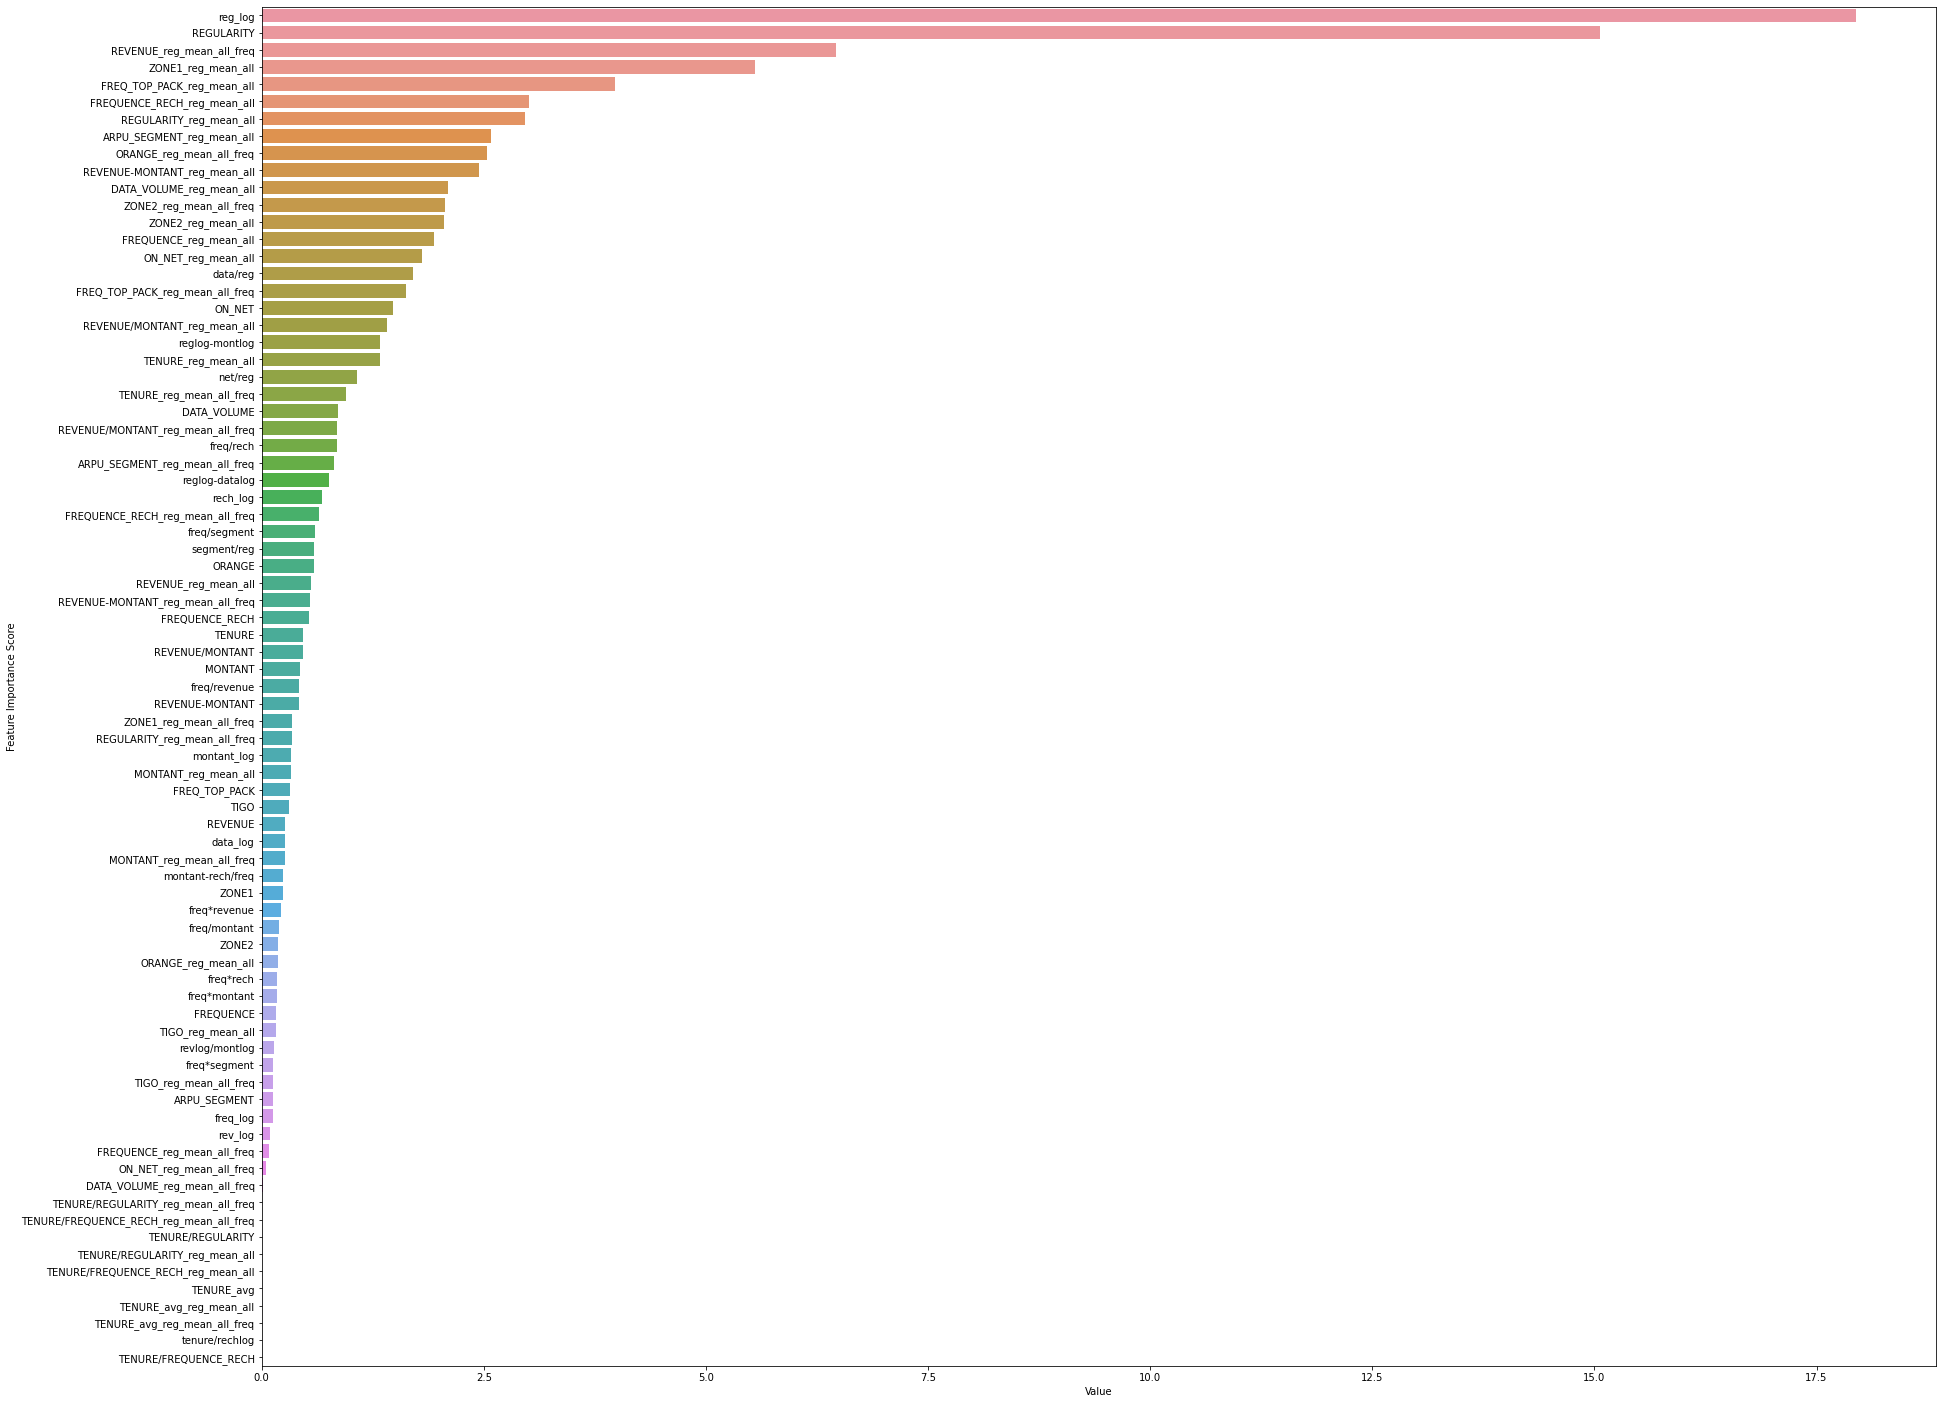

0.9316030571997743 0.9327634818133321 0.0003316943175879372


In [ ]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1')

func_= func(train, target, test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

### **MODEL 2 - XGBOOST**

================================Fold1====================================
[0]	validation_0-auc:0.903718
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.924442
[2]	validation_0-auc:0.925848
[3]	validation_0-auc:0.926165
[4]	validation_0-auc:0.926527
[5]	validation_0-auc:0.926646
[6]	validation_0-auc:0.927904
[7]	validation_0-auc:0.92806
[8]	validation_0-auc:0.928229
[9]	validation_0-auc:0.928349
[10]	validation_0-auc:0.9284
[11]	validation_0-auc:0.928633
[12]	validation_0-auc:0.928659
[13]	validation_0-auc:0.928716
[14]	validation_0-auc:0.928777
[15]	validation_0-auc:0.928816
[16]	validation_0-auc:0.92891
[17]	validation_0-auc:0.929427
[18]	validation_0-auc:0.929505
[19]	validation_0-auc:0.929526
[20]	validation_0-auc:0.929554
[21]	validation_0-auc:0.929576
[22]	validation_0-auc:0.929595
[23]	validation_0-auc:0.929621
[24]	validation_0-auc:0.929929
[25]	validation_0-auc:0.92995
[26]	validation_0-auc:0.929966
[27]	validation_0-auc:0.929983
[28]	vali

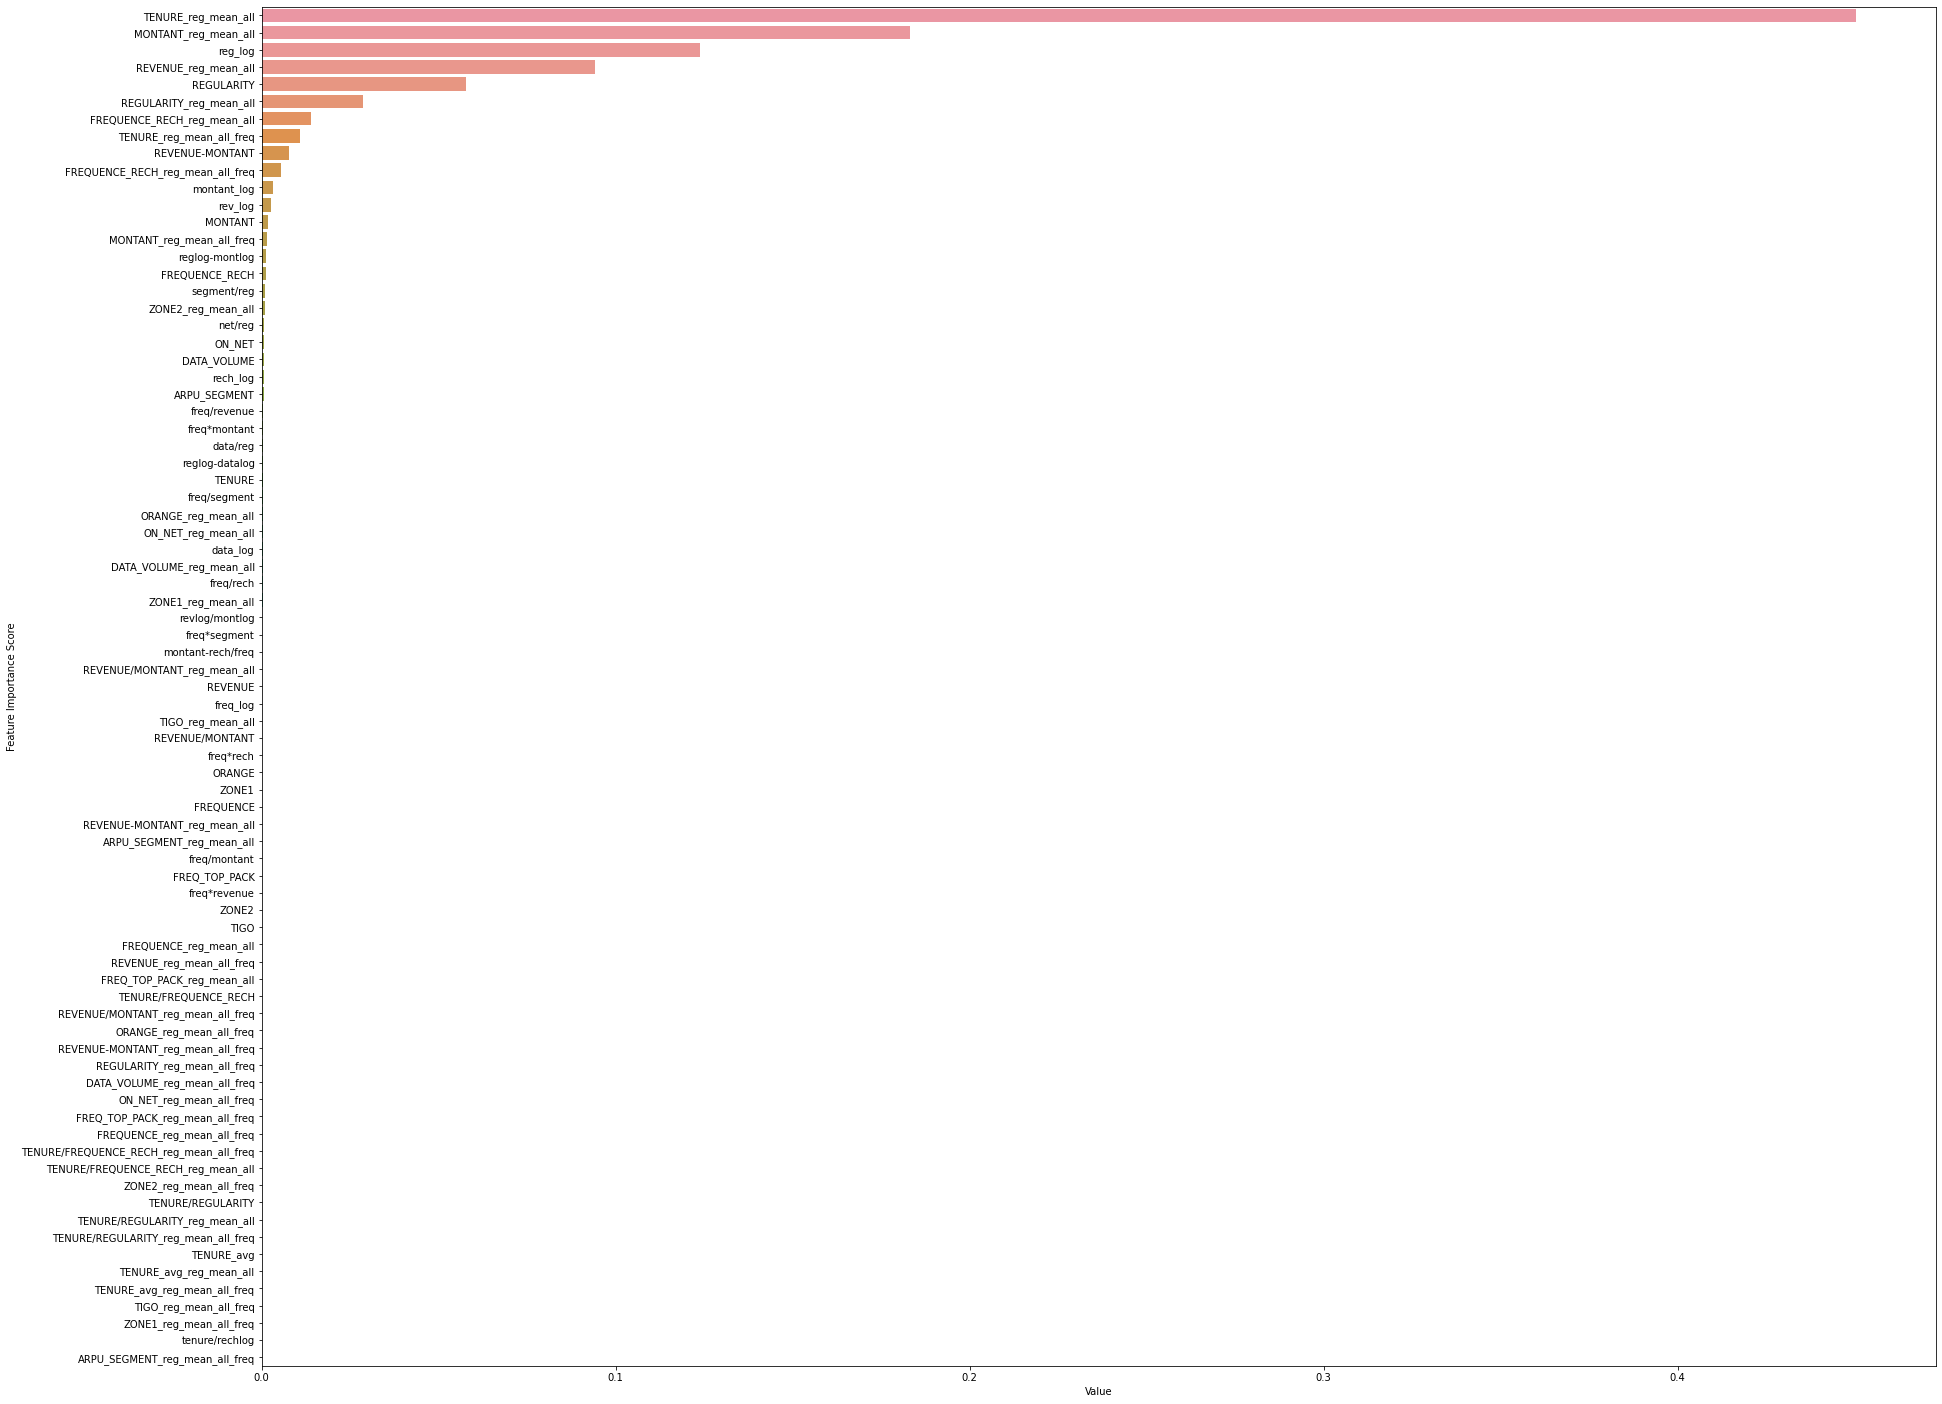

0.9314654195725257 0.9324587063722038 0.0003138164980363956


In [ ]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, tree_method='gpu_hist', gpu_id=0)

func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

### **MODEL 3 - LGBM**

================================Fold1====================================
[1]	valid_0's auc: 0.927834
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.928371
[3]	valid_0's auc: 0.928653
[4]	valid_0's auc: 0.928752
[5]	valid_0's auc: 0.928836
[6]	valid_0's auc: 0.929013
[7]	valid_0's auc: 0.929036
[8]	valid_0's auc: 0.92914
[9]	valid_0's auc: 0.929196
[10]	valid_0's auc: 0.929216
[11]	valid_0's auc: 0.929664
[12]	valid_0's auc: 0.929707
[13]	valid_0's auc: 0.929734
[14]	valid_0's auc: 0.929757
[15]	valid_0's auc: 0.929824
[16]	valid_0's auc: 0.930102
[17]	valid_0's auc: 0.930126
[18]	valid_0's auc: 0.930148
[19]	valid_0's auc: 0.930182
[20]	valid_0's auc: 0.930203
[21]	valid_0's auc: 0.930227
[22]	valid_0's auc: 0.930362
[23]	valid_0's auc: 0.930377
[24]	valid_0's auc: 0.930401
[25]	valid_0's auc: 0.930439
[26]	valid_0's auc: 0.93052
[27]	valid_0's auc: 0.930534
[28]	valid_0's auc: 0.930613
[29]	valid_0's auc: 0.930662
[30]	valid_0's auc: 0.930683
[31]	

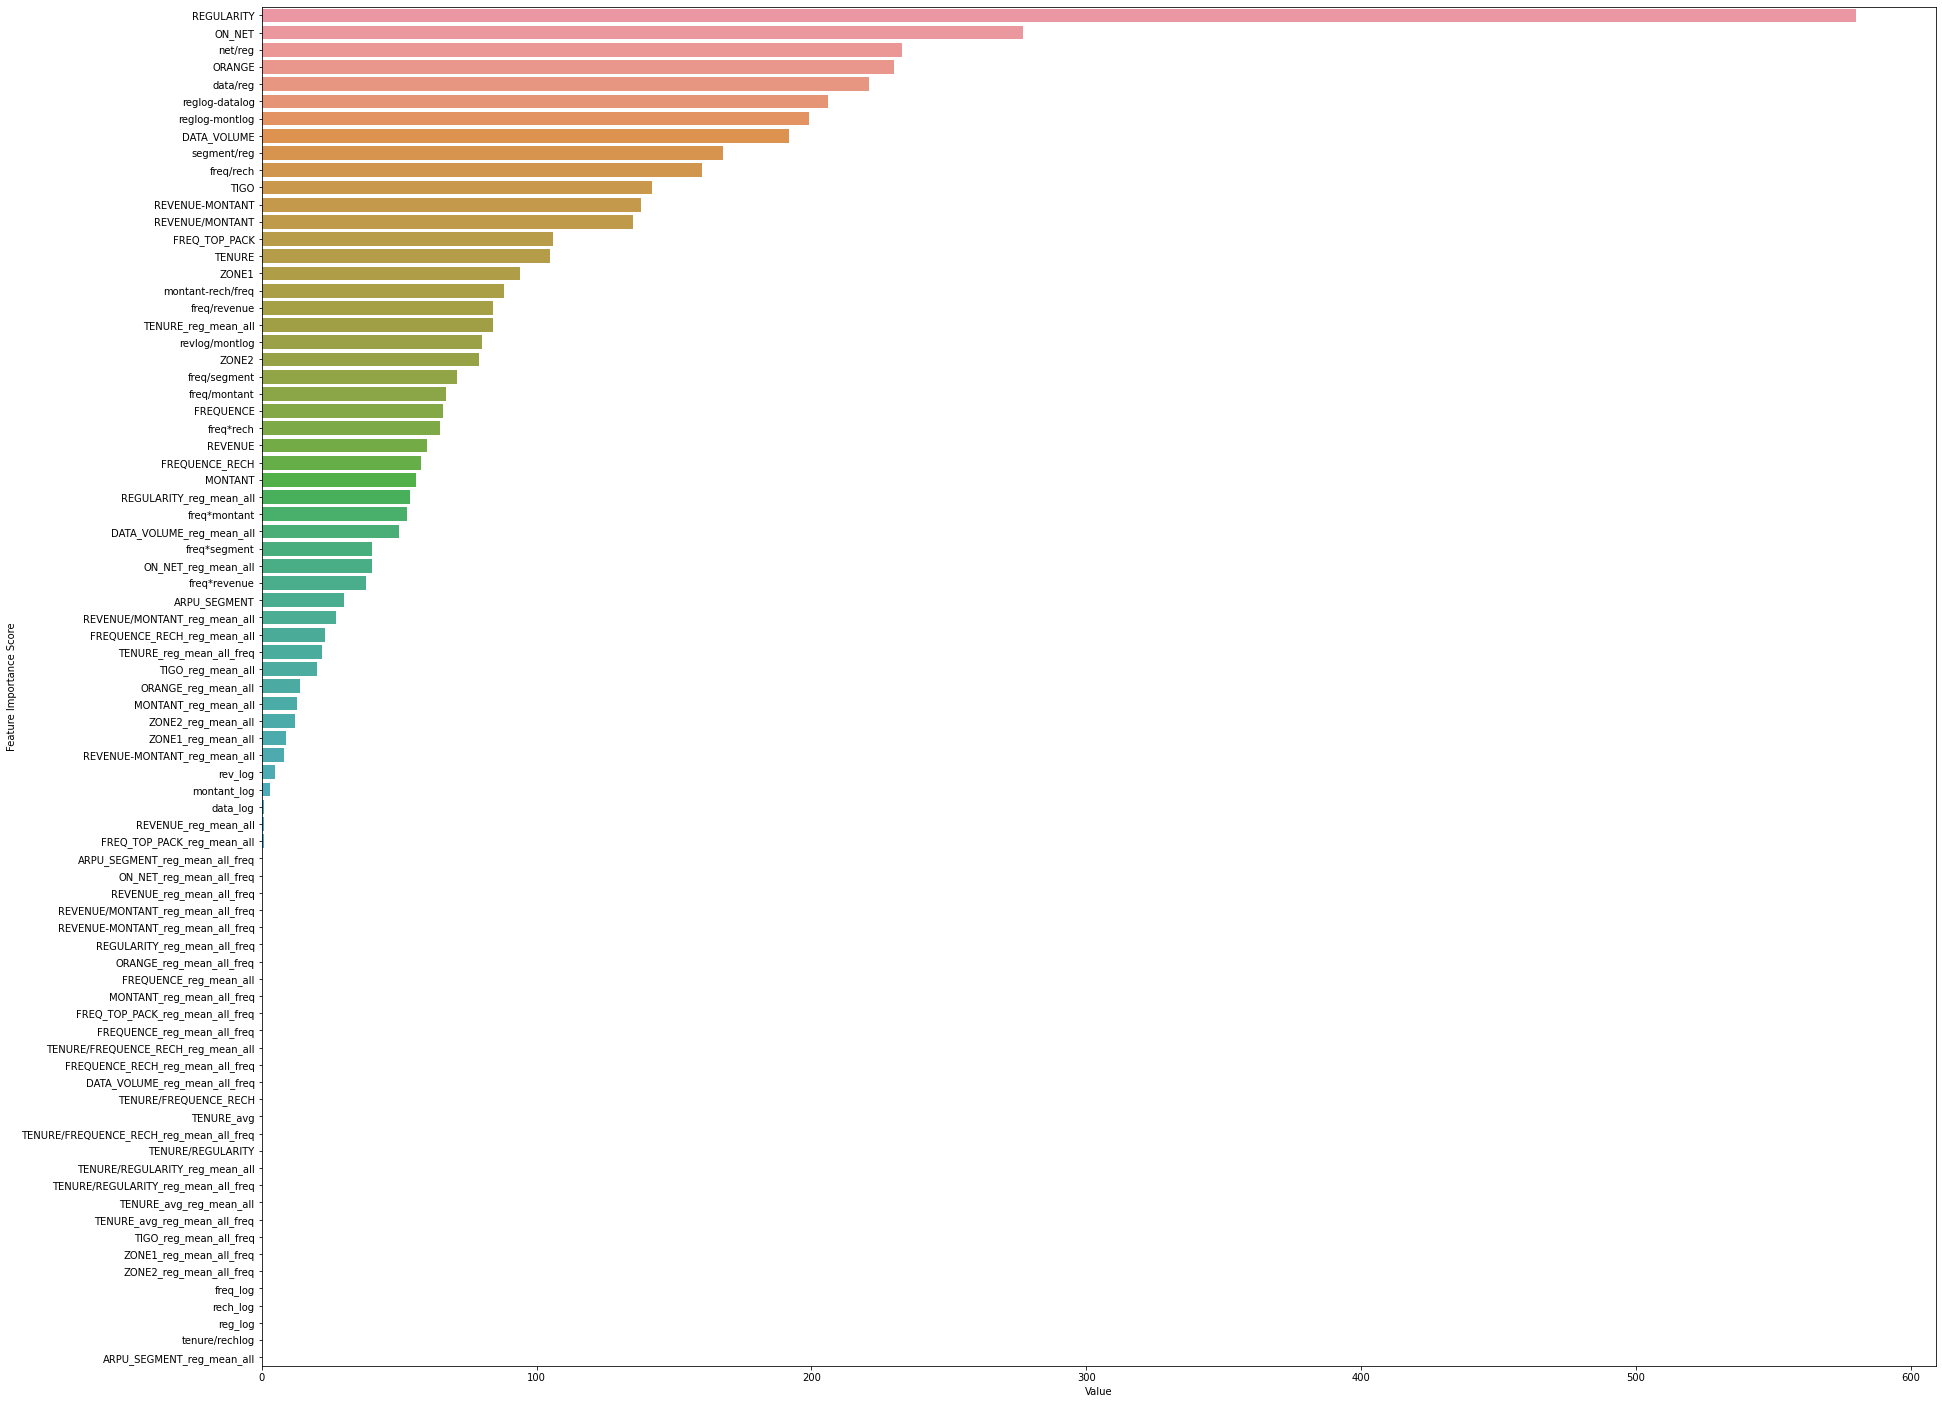

0.9314694632157424 0.9324622075840295 0.00032447304251136046


In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

### **STACKING**

In [ ]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)

### **SUBMISSION**

In [ ]:
submission['CHURN'] = predict

submission.to_csv('solution_stack.csv',index=False)

**FURTHER IMPROVEMENTS**
*   Feauture selection (Backward Elimination).
*   Better feature engineering(e.g. amount of missing columns in reach row/ flag if datapoint is missing)
*   Outlier handling
*   Train the different models on different random_seeds so as not to overfit a paticular seed
*   Add different features to different models, etc








